<a href="https://colab.research.google.com/github/PinaColadast/CDR3_prediction_case/blob/main/deepCDR_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
pip install logomaker

In [ ]:
#import library
import sys
import os
import glob

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
import logomaker



from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras import backend as K
from keras import callbacks
from keras.models import load_model



from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error



import scipy as sp
%unload_ext google.colab.data_table
np.random.seed(42)

The google.colab.data_table extension is not loaded.


In [ ]:
##read the files 
df_kd = pd.read_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task2_affinities_table.csv",
                    index_col = 0)
df_kd_test = pd.read_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task2_affinities_test.csv",
                         index_col = 0)


binding = glob.glob("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1*_binding*.csv")                  
df_binding = pd.concat([pd.read_csv(f, sep= ",", header=0, index_col=0) for f in binding])                     

In [ ]:
df_kd

In [ ]:
df_kd["log_kD"] = np.log(df_kd["KD (nM)"])
df_kd["affinity"] = ["high" if i <0 else ("low" if i>1.5 else "moderate") for i in df_kd["log_kD"] ]

moderate    41
low         32
high        17
Name: affinity, dtype: int64

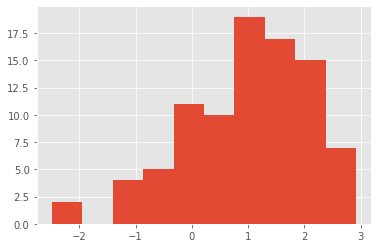

In [ ]:
plt.style.use("ggplot")
plt.hist(df_kd["log_kD"])

df_kd.affinity.value_counts()

In [ ]:
df_sequence_bd = pd.read_csv("/content/gdrive/My Drive/case_study/deepCDR/sequencing_binding_clean.csv", sep = "\t",
                             index_col = 0)

In [ ]:
def leven_distance(x,y):
    if len(x)==len(y):
      distance = np.sum([0 if x[i] == y[i] else 1 for i in range(len(x))])
    else:
      raise("sequence of different length")
    return distance

In [ ]:
sq_bd = df_sequence_bd.index.tolist()
sq_kd = df_kd.index.tolist() 

dist = np.zeros((len(sq_bd), len(sq_kd)))
for i in range(len(sq_bd)):
  for j in range(len(sq_kd)):
    dist[i,j] = leven_distance(sq_bd[i], sq_kd[j]) 


In [ ]:
def SequenceFrequencyCreator(df_sequence):
    aa_list = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H',
           'R', 'N', 'D', 'T']
    cnt_matrix = np.zeros((15, 20))
    dict_sequence = dict(zip(df_sequence.index, df_sequence["CloneCount"]))
    for i in df_sequence.index:
    # print(i)
      for j,k in enumerate(i):
        # print(j,k)
          cnt_matrix[j, aa_list.index(k)] += 1*dict_sequence[i]
    
    df_freq = pd.DataFrame(cnt_matrix/cnt_matrix.sum(axis=1)[:, np.newaxis], index = range(0,15), columns = aa_list)
    return df_freq
  

In [ ]:
sns.clustermap(dist)

In [ ]:
df_kd

,KD (nM),kon,koff,log_kD,affinity
AASeq,,,,,
CSRWSEPGFYTNDYW,0.08287,146300,0.000012,-2.490482,high
CSRWMETGFYTHDYW,0.13700,105600,0.000014,-1.987774,high
CSRWKGDGFYEHDYW,0.33450,137900,0.000046,-1.095118,high
CSRWPGPGMYTNDYW,0.38080,266800,0.000102,-0.965481,high
CSRWPGPGMYANDYW,0.38850,240200,0.000093,-0.945462,high
...,...,...,...,...,...
CSRWDRPGLYEHDYW,11.81000,60730,0.000717,2.468947,low
CSRWDVDGFYVFDYW,12.68000,331000,0.004198,2.540026,low
CSRYGQPGMYEHDYW,13.32000,134000,0.001785,2.589267,low



# the key is data augmentation....
low data regime: usually follows two steps
1. can we collect more data? 
2. data augmentation

data imputation....
data augmentation...

https://www.biorxiv.org/content/10.1101/2021.02.18.431877v1.full.pdf
K-means using the sequence before 

https://link.springer.com/article/10.1007/BF02300754
# what is a conservative substituion? 

In [ ]:
#protein AA replacement to augment data by chemistry meaning
# probability to substitute one AA according to dict aa_replacement in sequence 

## for each sequence in training data do 100 times
## each is a independent event follows bernoulli experiment with 0.1 as probability of substitution 
#from position 4aa to 13aa

aa_replacement = {"A":"V", "S":"T", "F":"Y", "K":"R", "C":"M", "D":"E", "N":"Q", "V":"I",
                  "P":"P", "G":"G", "W":"W", "H":"H", "T":"S", "Y":"F", "M":"C","E":"D", 
                  "Q":"N", "L":"L", "R":"K", "I":"V"}


def sequence_augmentation(sequence, n):
    events = np.random.binomial(1, 0.1, n)
    sub_position = np.random.randint(3,13, np.sum(events)).tolist()
    new_sequence = [sequence[0:i]+aa_replacement[sequence[i]]+sequence[i+1:] for i in sub_position]

    new_sequence.extend((n-np.sum(events))*[sequence])

    return new_sequence


In [ ]:
# for kD , adding noise by Gaussian distribution N~(0,1)

#create Gaussian noise, add 1% noise to the original data 
#(the noise level should be experiemented, let's stick to the noise level by rule of thumb)


df_train_1, df_test = train_test_split(df_kd, test_size = 0.2, random_state=42,
                                     stratify = df_kd.affinity)

df_train, df_val = train_test_split(df_train_1, test_size = 0.2, random_state = 42,
                                    stratify = df_train_1.affinity )




mu, sigma = 0, 1 
noise = np.random.normal(mu, sigma, 100).tolist()
noise_level = 0.01

aug_sequence = []
aug_y = []
aug_num = 100
x_raw = df_train.index
y_raw = df_train["log_kD"]
for i,j in enumerate(x_raw):
    aug_sequence.extend(sequence_augmentation(j, aug_num))
    y_noised = [(1-noise_level)*y_raw[i]+noise_level*noise[k] for k in range(0,100)]
    aug_y.extend(y_noised)


(array([ 181.,   19.,  200.,  201.,  738.,  561., 1181., 1023., 1097.,
         499.]),
 array([-2.50029164, -1.9582885 , -1.41628536, -0.87428221, -0.33227907,
         0.20972407,  0.75172721,  1.29373036,  1.8357335 ,  2.37773664,
         2.91973978]),
 <a list of 10 Patch objects>)

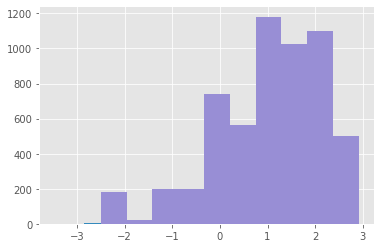

In [ ]:
plt.hist(df_kd["log_kD"])
plt.hist(noise)
plt.hist(aug_y)

# original distribution hasn't been shifted by the augmented y values make more
# sense 

In [ ]:
#lets take a look at distribution of augmented data
#making sequence logo of binders 
# lets look at that later.....need to modifiy frequency making 
plt.style.use("ggplot")
def sequence_logo_maker(df_freq):

  crp_logo = logomaker.Logo(df_freq,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

  crp_logo.style_spines(visible=False)
  crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
  crp_logo.style_xticks(fmt='%d', anchor=0)

  crp_logo.ax.set_ylabel("Frequency", labelpad=-1)
  crp_logo.ax.xaxis.set_ticks_position('none')

  crp_logo.ax.set_xticklabels(range(1,16,1))
  crp_logo.ax.xaxis.set_tick_params(pad=-1)

# sequence_logo_maker()


#ML: LSTM, CNN, random forest, transformer 
model representation? 
- NLP appraoch: language model: LSTM, BERT,
- sequence feature approach : random forest...? SVM
- one-hot encoding appraoch : CNN 


#Feature engineering

In [ ]:
#create positional one-hot encoding for CDR3 sequence
aa_list = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H',
           'R', 'N', 'D', 'T']


enc = OneHotEncoder(handle_unknown='ignore')
X_enc= np.array(aa_list).reshape(-1,1)
enc.fit(X_enc)
OneHotEncoder(handle_unknown='ignore')
# enc.categories_

def sequence_encoder(sequence):
    sequence_2D  = np.array([enc.transform(np.array([i]).reshape(1,-1)).toarray() for i in sequence]).squeeze().tolist()
    return sequence_2D




In [ ]:
#a bit slow

#random select 4000 sequences for training
select_index = np.random.randint(0,len(aug_sequence), 4000)

X_train = np.array([np.array(sequence_encoder(i)).reshape(15,20) for i in aug_sequence])[select_index]
y_train = np.array(aug_y)[select_index]

X_val  =  np.array([np.array(sequence_encoder(i)).reshape(15,20) for i in df_val.index])
y_val  =  df_val["log_kD"]

X_test =  np.array([np.array(sequence_encoder(i)).reshape(15,20) for i in df_test.index])
y_test =  df_test["log_kD"]


# let's create a baseline model without data augmentation


simple K-nearest neighbor model

In [ ]:
"""

using hamming distance to measure position-encoded protein sequence 

"""

# X_bs = np.array([np.array(sequence_encoder(i)).reshape(15,20).flatten() for i in df_kd.index])
# y_bs = df_kd.log_kD



# X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bs, y_bs, test_size=0.2, random_state=42,
#                                                     stratify = df_kd.affinity)


X_train_bs = np.array([np.array(sequence_encoder(i)).reshape(15,20).flatten() for i in aug_sequence])[select_index]
y_train_bs = np.array(aug_y)[select_index]

X_val_bs = np.array([np.array(sequence_encoder(i)).reshape(15,20).flatten() for i in df_val.index])
y_val_bs = df_val.log_kD

X_test_bs = np.array([np.array(sequence_encoder(i)).reshape(15,20).flatten() for i in df_test.index])
y_test_bs = df_test.log_kD
# cross-validation

kf = KFold(n_splits=5, shuffle=False)

MSE_cv   = []
spearman = []

for train_index, test_index in kf.split(X_train_bs):
    X_cv_train, X_cv_test = X_train_bs[train_index], X_train_bs[test_index]
    y_cv_train, y_cv_test = y_train_bs[train_index], y_train_bs[test_index]


    neigh = KNeighborsRegressor(n_neighbors=3, metric="hamming", weights = "distance")
    neigh.fit(X_cv_train, y_cv_train)
    
    y_cv_pred = neigh.predict(X_cv_test)
    
    MSE_cv.append(mean_squared_error(y_cv_pred, y_cv_test))
    spearman.append(sp.stats.spearmanr(y_cv_pred, y_cv_test))

In [ ]:
print("averaged mean squared error for 4-fold Cross validation is: {0:.3f}\nStandard deviation is : {1:.3f} \n Spearman is: {2:.3f}".format(np.mean(MSE_cv),
     np.std(MSE_cv), np.mean(spearman)))

averaged mean squared error for 4-fold Cross validation is: 0.003
Standard deviation is : 0.005 
 Spearman is: 0.499


In [ ]:
neigh = KNeighborsRegressor(n_neighbors=4, metric="hamming", weights = "distance")
neigh.fit(X_train_bs, y_train_bs)

y_pred = neigh.predict(X_val_bs)
print(sp.stats.spearmanr(y_pred, y_val_bs), 
mean_squared_error(y_pred, y_val_bs))

SpearmanrResult(correlation=0.37857142857142856, pvalue=0.16409082655922064) 0.9057406473878511


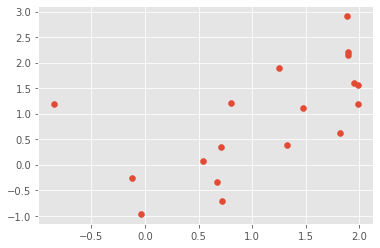

In [ ]:
plt.scatter(y_pred, y_test_bs)

# the baseline performance is really not so bad.....
# what about with data augmentation? 
# with data augmentation the KNN performance was worse 

#Machine learning model - CNN


In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [ ]:
from keras import metrics
from keras.optimizers import SGD

x_input = Input(shape=(15, 20))

#initial conv
conv = Conv1D(128, 3, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.25)(x)

# regression (linear activation function at the output layer)
x = Flatten()(x)
x = Dense(128, activation = "relu")(x)
x_output = Dense(1, activation = "linear", kernel_regularizer=l2(0.0001))(x)

opt = SGD(learning_rate=0.01, momentum=0.9)
model_CNN = Model(inputs=x_input, outputs=x_output)
model_CNN.compile(optimizer="adam", loss="mean_squared_error",
                  metrics=[metrics.RootMeanSquaredError()])

model_CNN.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 15, 20)]     0                                            
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 15, 128)      7808        input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 15, 128)      512         conv1d_90[0][0]                  
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 15, 128)      0           batch_normalization_72[0][0]     
___________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode= "min", patience=20, verbose=1)
mc = callbacks.ModelCheckpoint('/content/gdrive/My Drive/case_study/deepCDR/regre_best_model.h5', monitor='val_loss', mode='min')

history1 = model_CNN.fit(
    X_train, y_train,
    epochs = 150, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es,mc]
    )

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['root_mean_squared_error']
  val_acc = history.history['val_root_mean_squared_error']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training performance')
  plt.plot(x, val_acc, 'r', label='Validation performance')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train performance: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val performance: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test performance: ', test_score[1])

In [ ]:
# model_CNN.save_weights('/content/gdrive/My Drive/case_study/deepCDR/regre_model_resCNN.h5')
model_CNN.save_weights('/content/gdrive/My Drive/case_study/deepCDR/regre_model_resCNN2.h5')

In [ ]:
model_CNN.load_weights('/content/gdrive/My Drive/case_study/deepCDR/regre_best_model.h5')

In [ ]:
display_model_score(model_CNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test_bs.reshape(18,15,20), y_test_bs],
    32)

125/125 [==============================] - 1s 6ms/step - loss: 0.0153 - root_mean_squared_error: 0.0864
Train loss:  0.015272615477442741
Train performance:  0.08644779771566391
----------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step - loss: 0.7088 - root_mean_squared_error: 0.8372
Val loss:  0.7087544798851013
Val performance:  0.8372306227684021
----------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step - loss: 0.6801 - root_mean_squared_error: 0.8199
Test loss:  0.6801113486289978
Test performance:  0.8199462890625


In [ ]:
aa = model_CNN.predict(X_test_bs.reshape(18,15,20))

In [ ]:
sp.stats.spearmanr(aa, y_test_bs)

SpearmanrResult(correlation=0.7454828045597998, pvalue=0.00038375179844626363)

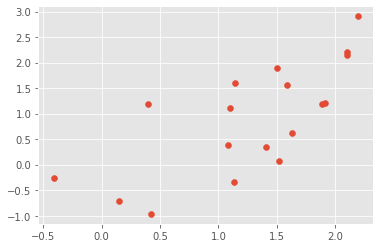

In [ ]:
plt.scatter(aa, y_test_bs)

In [ ]:
df_ex_test["Sequence_2D"] = df_ex_test.copy().apply(lambda row: sequence_encoder(row.name), axis = 1)
df_ex_test["Sequence_1D"] = [i[0] for i in df_ex_test["Sequence_2D"]]

In [ ]:
X_ex_test = np.array([np.array(x).reshape(15,20) for x in df_ex_test["Sequence_2D"]])

In [ ]:
y_pred = model_CNN.predict(X_ex_test, batch_size = 32)
y_pred_label = [1 if i >0.5 else 0 for i in y_pred.flatten()]

In [ ]:
df_ex_test["predicted_label"] = y_pred_label
df_predcited = df_ex_test.drop(columns = ["Sequence_2D", "Sequence_1D"])
df_predcited.to_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_predicted.csv")